In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import re
from imblearn.over_sampling import SMOTE
import torch
import pickle
import time
from sklearn.svm import SVC
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_excel('dataset_penyisihan_bdc_2024.xlsx')

def clean_text(text):
    # Remove Twitter handles (@user)
    text = re.sub(r'@\S+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove special characters but preserve spaces
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\brt\b', '', text, flags=re.IGNORECASE)
    # Convert to lowercase
    text = text.lower()
    return text

df['text'] = df['text'].apply(clean_text)

In [ ]:
df.head()

,text,label
0,kunjungan prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,anies dapat tepuk tangan meriah saat jadi rek...,Politik
2,emng bener sih pendukung ada yg goblok begitu ...,Demografi
3,sewaktu anies bersikap kritis ke kinerja pak ...,Politik
4,anies baswedan harap asn termasuk tni dan polr...,Politik


In [ ]:
label_counts = df['label'].value_counts()
print(label_counts)


label
Politik                    2972
Sosial Budaya               587
Pertahanan dan Keamanan     400
Ideologi                    400
Ekonomi                     367
Sumber Daya Alam            192
Demografi                    62
Geografi                     20
Name: count, dtype: int64


In [ ]:
duplicates_text = df[df.duplicated(subset=['text'])]
print("Duplicate tweets:")
print(duplicates_text)

print(f"Number of duplicate: {duplicates_text.shape[0]}")

if not duplicates_text.empty:
    print("Rows with duplicates based on 'text' column:")
    print(df[df['text'].duplicated(keep=False)])

Duplicate tweets:
                                                   text  \
57     abah anies ingin mengangkat martabat petani a...   
60     sewaktu anies bersikap kritis ke kinerja pak ...   
104    anak muda indonesia the future of this nation...   
128    bulan januari ini serangan dari kubu dkk akan...   
143    bulan januari ini serangan dari kubu dkk akan...   
...                                                 ...   
4959  bukan cuma tampilan luarnya tapi kebijakan gan...   
4971   menjelang tengah malam ini aku mau ucapkan te...   
4983  investorfriendly pasangan capres cawapres ganj...   
4991   bulan januari ini serangan dari kubu dkk akan...   
4994   tanggapan serius ganjar atas tindakan pengani...   

                        label  
57              Sosial Budaya  
60                    Politik  
104                  Ideologi  
128   Pertahanan dan Keamanan  
143   Pertahanan dan Keamanan  
...                       ...  
4959                 Ideologi  
4971             

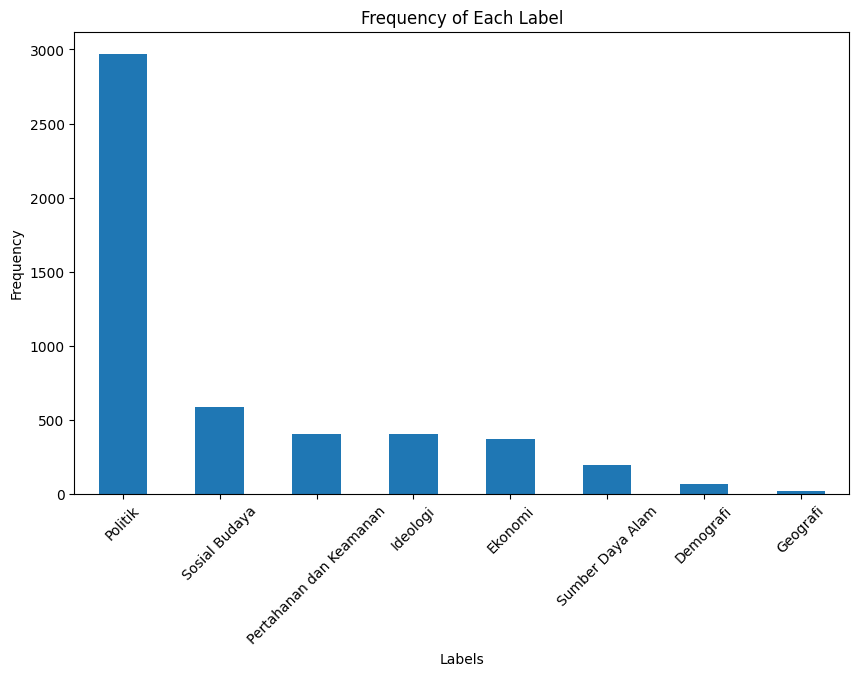

In [ ]:
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Frequency of Each Label')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

label
Sumber Daya Alam           2972
Politik                    2972
Demografi                  2972
Pertahanan dan Keamanan    2972
Ideologi                   2972
Ekonomi                    2972
Sosial Budaya              2972
Geografi                   2972
Name: count, dtype: int64


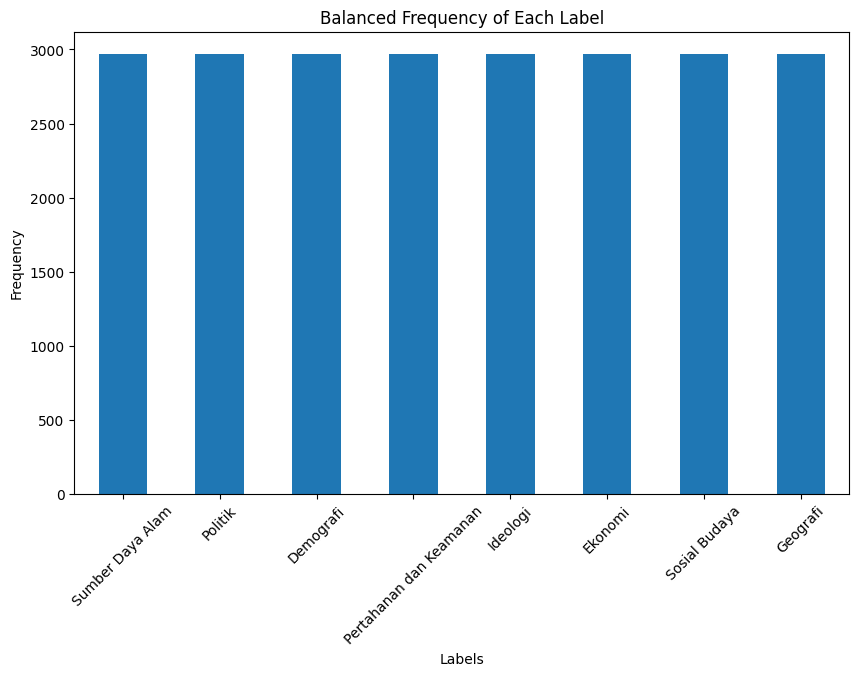

In [ ]:
X = df['text']
y = df['label']
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Perform SMOTE oversampling
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

# Convert the resampled data back to a DataFrame
balanced_label_counts = pd.Series(y_resampled).value_counts()
print(balanced_label_counts)

# Plot the balanced frequency of each label
plt.figure(figsize=(10, 6))
balanced_label_counts.plot(kind='bar')
plt.title('Balanced Frequency of Each Label')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Start time measurement
start_time = time.time()

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load your DataFrame 'df' with columns 'text' and 'label'
texts = df['text'].tolist()
labels = df['label'].tolist()

# Encode labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Load pre-trained SBERT model
model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device=device)

# Generate embeddings for the texts
embeddings = model.encode(texts, convert_to_tensor=True, device=device)
smote = SMOTE()
embeddings_smote, labels_smote = smote.fit_resample(embeddings.cpu().numpy(), encoded_labels)

# Split the resampled data into training and validation sets
embeddings_train, embeddings_val, labels_train, labels_val = train_test_split(embeddings_smote, labels_smote, test_size=0.2, random_state=42, stratify=labels_smote)

# Train the SVC model without parameter tuning using the best parameters
svc = SVC(kernel='rbf', C=100, gamma='scale')

# Measure training time
train_start_time = time.time()
svc.fit(embeddings_train, labels_train)
train_end_time = time.time()

# Evaluate the model on the validation set
val_predictions = svc.predict(embeddings_val)
accuracy = accuracy_score(labels_val, val_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(labels_val, val_predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# Save the classifier and label encoder to pickle files
with open('sbert_classifierwithSVC.pkl', 'wb') as f:
    pickle.dump(svc, f)

with open('label_encoderwithSVC.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Classifier and label encoder saved successfully.")

# Print time measurements
end_time = time.time()
print(f'Total time (including preprocessing): {end_time - start_time} seconds')
print(f'Training time: {train_end_time - train_start_time} seconds')

Using device: cuda


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Accuracy: 0.9775021026072329
Precision: 0.9779511657028057
Recall: 0.9775021026072329
F1-score: 0.9772329208140285
Classifier and label encoder saved successfully.
Total time (including preprocessing): 36.213130474090576 seconds
Training time: 17.19632625579834 seconds


In [ ]:
Hasil = pd.read_excel('dataset_unlabeled_penyisihan_bdc_2024.xlsx')  # Replace with the correct path if necessary
Hasil['Text'] = Hasil['Text'].apply(clean_text)
new_texts = Hasil['Text'].tolist()
new_embeddings = model.encode(new_texts, convert_to_tensor=True, device=device)

new_predictions = svc.predict(new_embeddings.cpu().numpy())

# Decode the predicted labels back to the original label names
predicted_labels = label_encoder.inverse_transform(new_predictions)

# Add the predicted labels to the DataFrame
Hasil['Label'] = predicted_labels

# Export the DataFrame to an Excel file
Hasil.to_excel('HasilSVM.xlsx', index=False)

print("Predictions added to 'Hasil' DataFrame and exported to 'HasilSVM.xlsx'.")

Predictions added to 'Hasil' DataFrame and exported to 'HasilSVM.xlsx'.


Using device: cuda


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fold 1
Accuracy of this fold 0.973717409587889


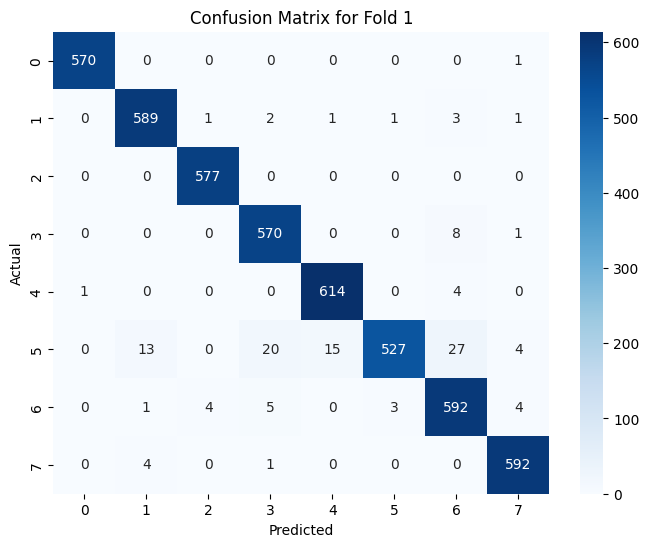

Fold 2
Accuracy of this fold 0.9753943217665615


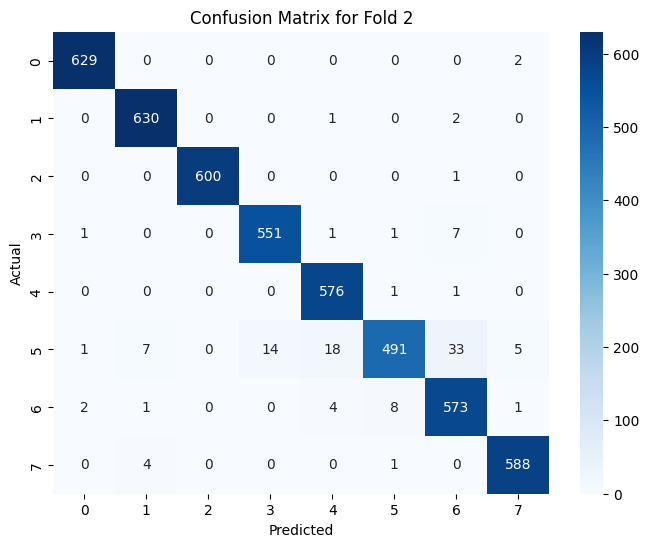

Fold 3
Accuracy of this fold 0.9735015772870662


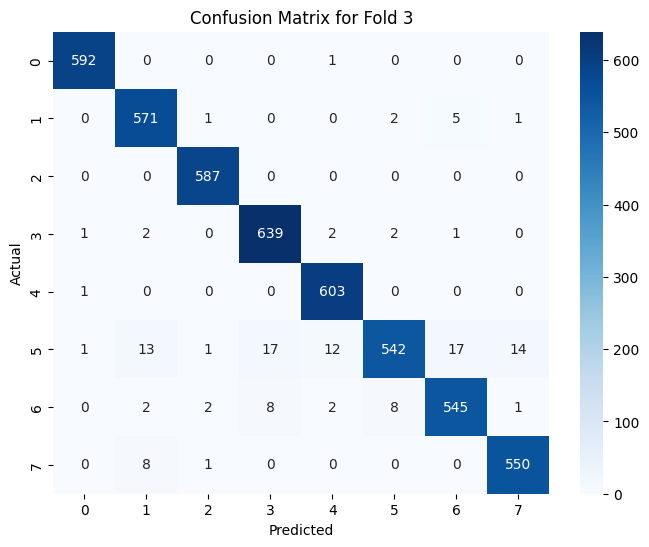

Fold 4
Accuracy of this fold 0.9793901156677182


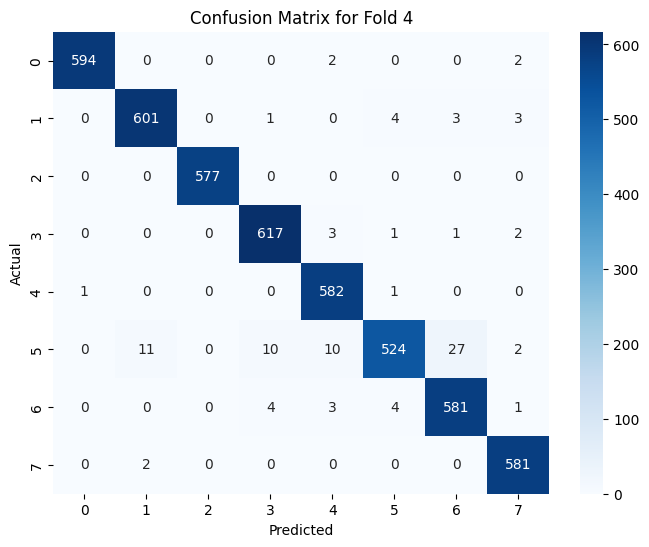

Fold 5
Accuracy of this fold 0.9716088328075709


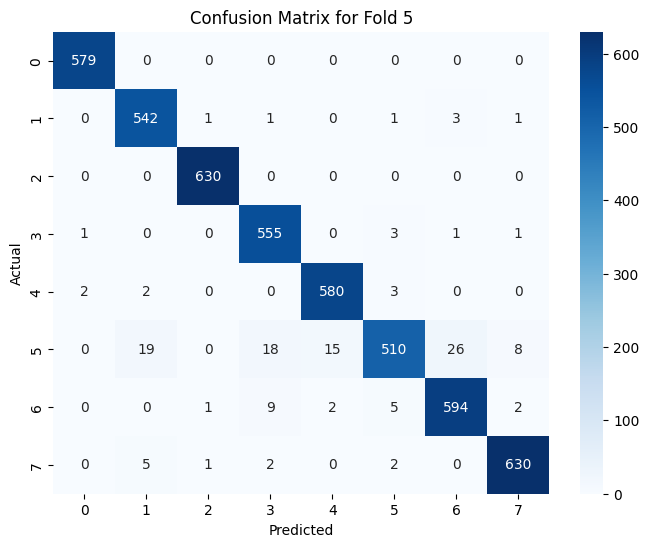

Mean Accuracy: 0.9747224514233611
Mean Precision: 0.9750155908312671
Mean Recall: 0.9747224514233611
Mean F1-score: 0.9743777723626202
Total time (including preprocessing and cross-validation): 128.759206533432 seconds


In [ ]:

# Start time measurement
start_time = time.time()

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load your DataFrame 'df' with columns 'text' and 'label'
# Assuming df is already loaded
texts = df['text'].tolist()
labels = df['label'].tolist()

# Encode labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Load pre-trained SBERT model
model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device=device)

# Generate embeddings for the texts
embeddings = model.encode(texts, convert_to_tensor=True, device=device)
smote = SMOTE()
embeddings_smote, labels_smote = smote.fit_resample(embeddings.cpu().numpy(), encoded_labels)

# Define the SVC model with best parameters
svc = SVC(kernel='rbf', C=100, gamma='scale')

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
confusion_matrices = []

# Cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(embeddings_smote)):
    print(f"Fold {fold + 1}")
    embeddings_train, embeddings_val = embeddings_smote[train_index], embeddings_smote[val_index]
    labels_train, labels_val = labels_smote[train_index], labels_smote[val_index]

    # Train the SVC model
    svc.fit(embeddings_train, labels_train)

    # Evaluate the model on the validation set
    val_predictions = svc.predict(embeddings_val)
    accuracy = accuracy_score(labels_val, val_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_val, val_predictions, average='weighted')
    print(f"Accuracy of this fold {accuracy}")
    conf_matrix = confusion_matrix(labels_val, val_predictions)

    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    confusion_matrices.append(conf_matrix)

    # Print confusion matrix for the fold
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Calculate mean metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)

# Print mean metrics
print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1-score: {mean_f1_score}')

# Print total time taken
end_time = time.time()
print(f'Total time (including preprocessing and cross-validation): {end_time - start_time} seconds')


Using device: cuda


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


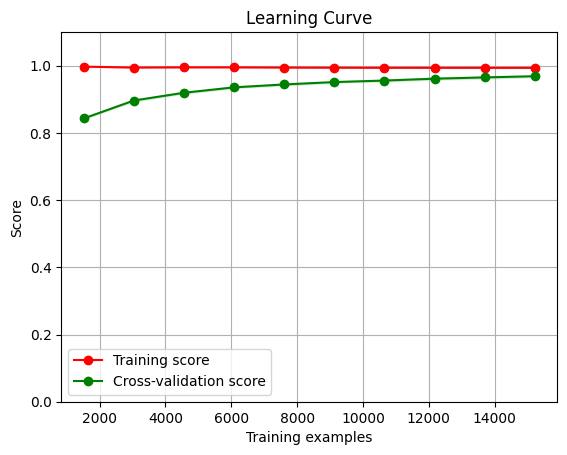

Accuracy: 0.9766610597140454
Precision: 0.976894605130911
Recall: 0.9766610597140454
F1-score: 0.9763575923201825
Training time: 17.50 seconds
Total time: 546.54 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import time
import torch
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Measure start time
start_time = time.time()

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load your DataFrame 'df' with columns 'text' and 'label'
texts = df['text'].tolist()
labels = df['label'].tolist()

# Encode labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Load pre-trained SBERT model
model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device=device)

# Generate embeddings for the texts
embeddings = model.encode(texts, convert_to_tensor=True, device=device)
smote = SMOTE()
embeddings_smote, labels_smote = smote.fit_resample(embeddings.cpu().numpy(), encoded_labels)

# Split the resampled data into training and validation sets
embeddings_train, embeddings_val, labels_train, labels_val = train_test_split(embeddings_smote, labels_smote, test_size=0.2, random_state=42, stratify=labels_smote)

# Define the SVC model
svc = SVC(kernel='rbf', C=100, gamma='scale')

# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(svc, embeddings_train, labels_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
plt.grid()

# Plot train scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')

# Plot validation scores
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.legend(loc='best')
plt.show()

# Measure training time
train_start_time = time.time()
svc.fit(embeddings_train, labels_train)
train_end_time = time.time()

# Evaluate the model on the validation set
val_predictions = svc.predict(embeddings_val)
accuracy = accuracy_score(labels_val, val_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(labels_val, val_predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Training time: {train_end_time - train_start_time:.2f} seconds')
print(f'Total time: {time.time() - start_time:.2f} seconds')
